HEADER

In [3]:
import pandas as pd
import os

data_folder = r"C:\Users\vicky\Desktop\Football-analytics\Datasets\xP_master"

# Dictionary to hold each DataFrame
dfs = {}

# Load each file
for filename in os.listdir(data_folder):
    if filename.endswith(".parquet"):
        full_path = os.path.join(data_folder, filename)
        dfs[filename] = pd.read_parquet(full_path)
        print(f"Loaded {filename} with shape {dfs[filename].shape}")

# Access individual DataFrames, for example:
competitions_df = dfs['competitions.parquet']
matches_df = dfs['matches.parquet']
model_features_df = dfs['model_features_X.parquet']
passes_xp_df = dfs['passes_features_with_xp.parquet']
passes_raw_df = dfs['passes_raw.parquet']

Loaded competitions.parquet with shape (8, 12)
Loaded matches.parquet with shape (540, 22)
Loaded model_features_X.parquet with shape (495781, 213)
Loaded passes_features_with_xp.parquet with shape (495781, 349)
Loaded passes_raw.parquet with shape (496100, 122)


In [9]:
passes_xp_df.head()

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,pp_From Counter,pp_From Free Kick,pp_From Goal Kick,pp_From Keeper,pp_From Kick Off,pp_From Throw In,pp_Other,pp_Regular Play,completed,xP
0,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.769447
1,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.982276
2,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.952742
3,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.753151
4,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.811358


In [15]:
len(passes_xp_df)

495781

In [60]:
# === 1️⃣ Create a DataFrame of player stats ===
player_stats = passes_xp_df.groupby('player').agg(
    avg_xP=('xP', 'mean'),            # average xP per pass
    total_xP=('xP', 'sum'),           # total xP
    total_completed=('completed', 'sum'),  # total passes actually completed
    total_xP_difference=('xP_difference', 'sum'),  # sum of xP - completed
    num_passes=('xP', 'count')        # number of passes
).sort_values('avg_xP', ascending=False)

# === 2️⃣ Add the list of matches each player played in ===
player_matches = passes_xp_df.groupby('player')['match_id'].unique()

# === 3️⃣ Combine stats and matches ===
player_profile = player_stats.join(player_matches.rename('match_id'))

# === 4️⃣ Optional: filter for players with at least 3 matches and 30 passes ===
min_matches = 3
min_passes = 30

player_profile_filtered = player_profile[
    (player_profile['match_id'].apply(len) >= min_matches) &
    (player_profile['num_passes'] >= min_passes)
]

# Add avg_xP_difference column
player_profile_filtered['avg_xP_difference'] = player_profile_filtered['total_xP_difference'] / player_profile_filtered['num_passes']

C:\Users\vicky\AppData\Local\Temp\ipykernel_7504\192414557.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_profile_filtered['avg_xP_difference'] = player_profile_filtered['total_xP_difference'] / player_profile_filtered['num_passes']


In [61]:
# Create a mapping from match_id to competition
match_to_competition = matches_df.set_index('match_id')['competition'].to_dict()

# Add a new column with the competition names for each pass
passes_xp_df['competition_name'] = passes_xp_df['match_id'].map(match_to_competition)

# Now group by player and collect unique competitions they played in
player_competitions = passes_xp_df.groupby('player')['competition_name'].unique()

# Merge this with the player_profile_filtered
player_profile_filtered = player_profile_filtered.join(
    player_competitions.rename('competitions')
)

# Reset index and avoid column name conflict
player_profile_clean = player_profile_filtered.reset_index(drop=False)

# If 'competitions' also exists and conflicts, you can rename it first:
# player_profile_filtered = player_profile_filtered.rename(columns={'competitions': 'competitions_list'})

player_profile_clean.head(10)


,player,avg_xP,total_xP,total_completed,total_xP_difference,num_passes,match_id,avg_xP_difference,competitions
0,Do-Yeon Kim,0.873803,119.711032,131,-11.288968,137,"[22945, 22981, 22921]",-0.082401,[International - Women's World Cup]
1,Gloriana Jesus Villalobos Vega,0.863426,36.263896,37,-0.736104,42,"[3893823, 3893791, 3893805]",-0.017526,[International - Women's World Cup]
2,Kanjana Sungngoen,0.861638,63.761199,63,0.761199,74,"[22943, 22973, 68343]",0.010286,[International - Women's World Cup]
3,Saki Kumagai,0.860890,431.306100,455,-23.693900,501,"[3893822, 3902239, 3901734, 3893805, 3893793, ...",-0.047293,[International - Women's World Cup]
4,Naomi Layzell,0.858053,50.625124,48,2.625124,59,"[3775569, 3775596, 3775637, 3775631, 3775621, ...",0.044494,[England - FA Women's Super League]
5,Emmi Alanen,0.857022,111.412907,107,4.412907,130,"[3835338, 3835329, 3835321]",0.033945,[Europe - UEFA Women's Euro]
6,Eva Nyström,0.852274,204.545732,216,-11.454268,240,"[3998852, 3998845, 3998836]",-0.047726,[Europe - UEFA Women's Euro]
7,María Isabel Rodríguez Rivero,0.849745,47.585695,52,-4.414305,56,"[3893806, 3893822, 3893791]",-0.078827,[International - Women's World Cup]
8,Sara Björk Gunnarsdóttir,0.847534,48.309432,46,2.309432,57,"[3835342, 3835326, 3835334]",0.040516,[Europe - UEFA Women's Euro]
9,Nana Ichise,0.845275,146.232519,156,-9.767481,173,"[22961, 68337, 69188]",-0.056459,[International - Women's World Cup]


In [104]:
# Check number of competitions per player
player_profile_clean['num_competitions'] = player_profile_clean['competitions'].apply(lambda x: len(x))

# Filter players with more than 1 competition
players_multiple_competitions = player_profile_clean[player_profile_clean['num_competitions'] > 1]

# Display
players_multiple_competitions[['player', 'competitions', 'num_competitions']]

,player,competitions,num_competitions
13,Jill Roord,"[England - FA Women's Super League, Europe - U...",3
21,Louise Quinn,"[England - FA Women's Super League, Internatio...",2
24,Aïssatou Tounkara,"[Europe - UEFA Women's Euro, International - W...",2
26,Wieke Hendrikje Maria Kaptein,"[Europe - UEFA Women's Euro, International - W...",2
27,Guro Bergsvand,"[Europe - UEFA Women's Euro, International - W...",2
...,...,...,...
1046,Zecira Musovic,"[England - FA Women's Super League, Internatio...",2
1050,Jennifer Miley Falk,"[Europe - UEFA Women's Euro, International - W...",2
1052,Courtney Brosnan,"[England - FA Women's Super League, Internatio...",2
1060,Kailen Mary Iacovoni Sheridan,"[United States of America - NWSL, Internationa...",2


In [119]:
# 1️⃣ Map match_id to competition
match_to_competition = matches_df.set_index('match_id')['competition'].to_dict()
passes_xp_df['competition_name'] = passes_xp_df['match_id'].map(match_to_competition)

# 2️⃣ Aggregate per player per competition
player_comp_stats = passes_xp_df.groupby(['player', 'competition_name']).agg(
    total_xP=('xP', 'sum'),
    total_completed=('completed', 'sum'),
    num_passes=('xP', 'count')  # count rows as number of passes
).reset_index()

# 3️⃣ Calculate derived metrics
player_comp_stats['avg_xP'] = player_comp_stats['total_xP'] / player_comp_stats['num_passes']
player_comp_stats['total_xP_difference'] = player_comp_stats['total_xP'] - player_comp_stats['total_completed']
player_comp_stats['avg_xP_difference'] = player_comp_stats['total_xP_difference'] / player_comp_stats['num_passes']

# 4️⃣ Prepare player profile
# Reset index if 'player' is the index
if player_profile_filtered.index.name == 'player':
    player_profile_filtered = player_profile_filtered.reset_index()

# Drop duplicate 'player' columns if they exist
player_profile_filtered = player_profile_filtered.loc[:, ~player_profile_filtered.columns.duplicated()]

# Keep only relevant profile columns
profile_cols_to_keep = ['player', 'team', 'position']  # adjust to columns that actually exist
existing_profile_cols = [c for c in profile_cols_to_keep if c in player_profile_filtered.columns]
player_profile_base = player_profile_filtered[['player'] + existing_profile_cols]

# 5️⃣ Merge stats with profile info
player_profile_long = player_comp_stats.merge(player_profile_base, on='player', how='left')

# 6️⃣ Reorder columns
cols_order = ['player'] + existing_profile_cols + [
    'competition_name', 'avg_xP', 'total_xP', 'total_completed',
    'total_xP_difference', 'num_passes', 'avg_xP_difference'
]
player_profile_long = player_profile_long[cols_order]

# 7️⃣ Sort by player, then avg_xP_difference within player
player_profile_long = player_profile_long.sort_values(by=['player', 'avg_xP_difference'], ascending=[True, False]).reset_index(drop=True)

# Inspect
player_profile_long.head(20)

ValueError: The column label 'player' is not unique.

In [120]:
# List all column names and check for duplicates
print(player_profile_filtered.columns.tolist())

# Or check specifically for duplicated column names
duplicates = player_profile_filtered.columns[player_profile_filtered.columns.duplicated()]
print("Duplicated columns:", duplicates)

['player', 'avg_xP', 'total_xP', 'total_completed', 'total_xP_difference', 'num_passes', 'match_id', 'avg_xP_difference', 'competitions']
Duplicated columns: Index([], dtype='object')


In [116]:
# 1️⃣ Ensure the long table exists (from previous step)
# player_profile_long

# 2️⃣ Sort by player first, then by avg_xP_difference descending
player_profile_long_sorted = (
    player_profile_long
    .sort_values(by=['player', 'avg_xP_difference'], ascending=[True, False])
    .reset_index(drop=True)
)

# 3️⃣ Inspect
player_profile_long_sorted.head(20)

,player,avg_xP,total_xP,total_completed,total_xP_difference,num_passes,avg_xP_difference,competition_name
0,Abbey-Leigh Stringer,0.797615,875.781011,841,34.781011,1098,0.031677,England - FA Women's Super League
1,Abbi Grant,0.799643,263.082515,245,18.082515,329,0.054962,England - FA Women's Super League
2,Abbie Magee,0.721923,27.433057,27,0.433057,38,0.011396,Europe - UEFA Women's Euro
3,Abbie McManus,0.771718,1900.742083,1995,-94.257917,2463,-0.038270,England - FA Women's Super League
4,Abbie McManus,0.771718,1900.742083,1995,-94.257917,2463,-0.038270,International - Women's World Cup
5,Abby Dahlkemper,0.776429,1163.867717,1267,-103.132283,1499,-0.068801,England - FA Women's Super League
6,Abby Dahlkemper,0.776429,1163.867717,1267,-103.132283,1499,-0.068801,United States of America - NWSL
7,Abby Dahlkemper,0.776429,1163.867717,1267,-103.132283,1499,-0.068801,International - Women's World Cup
8,Abby Erceg,0.783569,503.051324,521,-17.948676,642,-0.027957,United States of America - NWSL
9,Abby Erceg,0.783569,503.051324,521,-17.948676,642,-0.027957,International - Women's World Cup


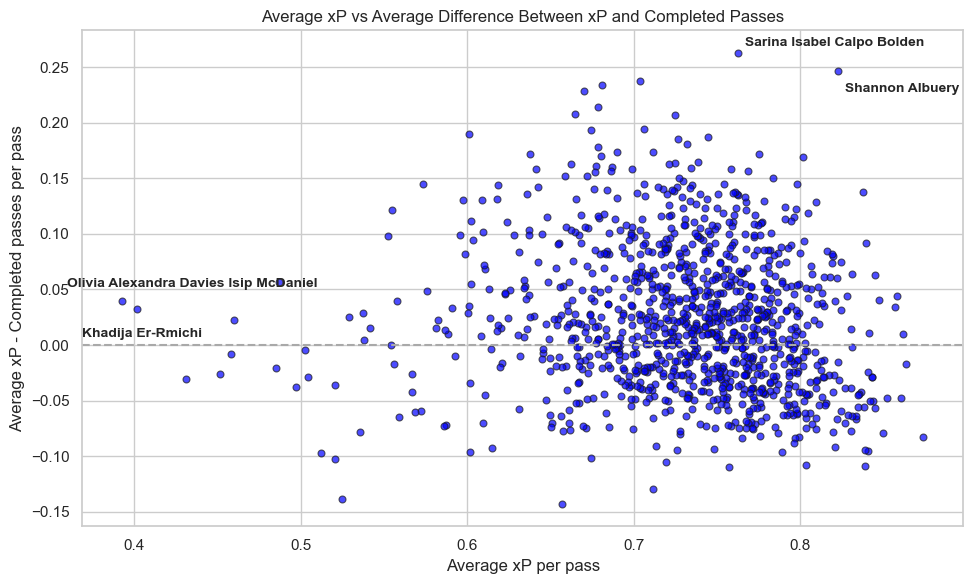

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Scatter plot with smaller points and thin border
sns.scatterplot(
    data=player_profile_filtered,
    x='avg_xP',
    y='avg_xP_difference',
    color='blue',
    s=25,               # even smaller points
    alpha=0.7,
    edgecolor='k',      # thin border
    linewidth=0.8
)

# Horizontal line for xP = Completed
plt.axhline(0, color='darkgrey', linestyle='--', label='xP = Completed Passes')

# Annotate the 2 highest points on y-axis with offsets
top_diff_players = player_profile_filtered.nlargest(2, 'avg_xP_difference')
offsets_top = [(5, 5), (5, -15)]  # fine-tuned offsets
for (i, (_, row)) in enumerate(top_diff_players.iterrows()):
    plt.annotate(
        row.name,
        xy=(row['avg_xP'], row['avg_xP_difference']),
        xytext=offsets_top[i],
        textcoords='offset points',
        fontsize=10,
        weight='bold'
    )

# Annotate the 2 leftmost points on x-axis with adjusted offsets to avoid axis
leftmost_players = player_profile_filtered.nsmallest(2, 'avg_xP')
offsets_left = [(-40, 10), (-40, -20)]  # shift right/left and up/down
for (i, (_, row)) in enumerate(leftmost_players.iterrows()):
    plt.annotate(
        row.name,
        xy=(row['avg_xP'], row['avg_xP_difference']),
        xytext=offsets_left[i],
        textcoords='offset points',
        fontsize=10,
        weight='bold'
    )

plt.title('Average xP vs Average Difference Between xP and Completed Passes')
plt.xlabel('Average xP per pass')
plt.ylabel('Average xP - Completed passes per pass')
plt.tight_layout()
plt.show()

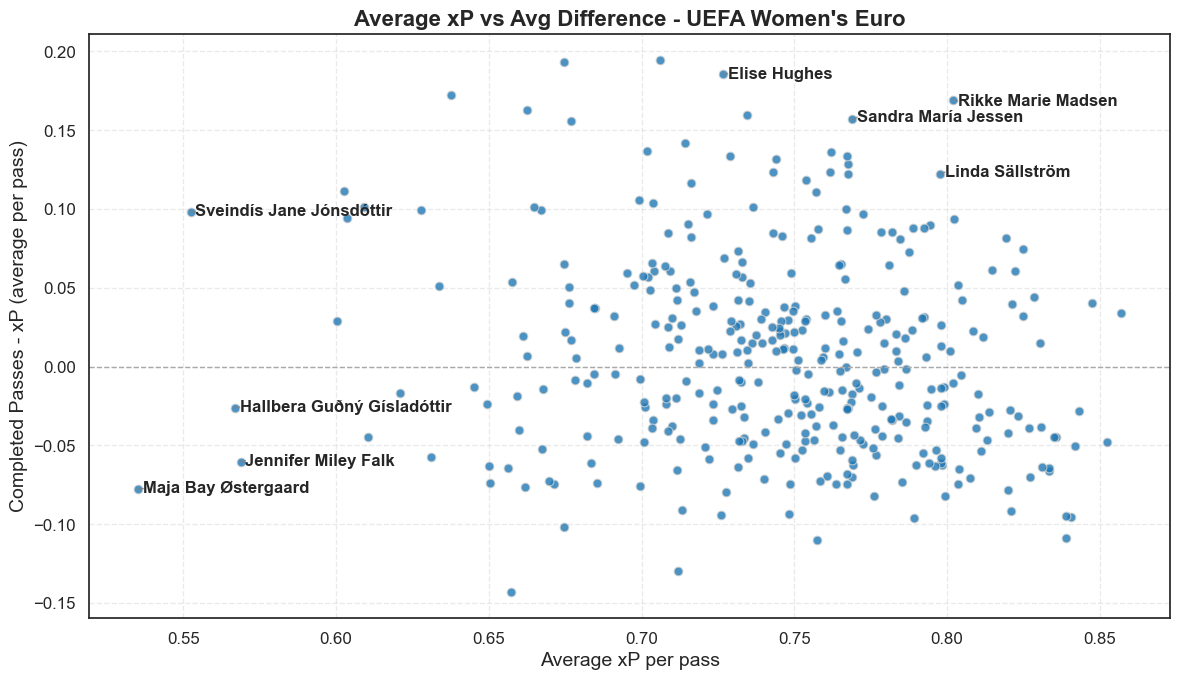

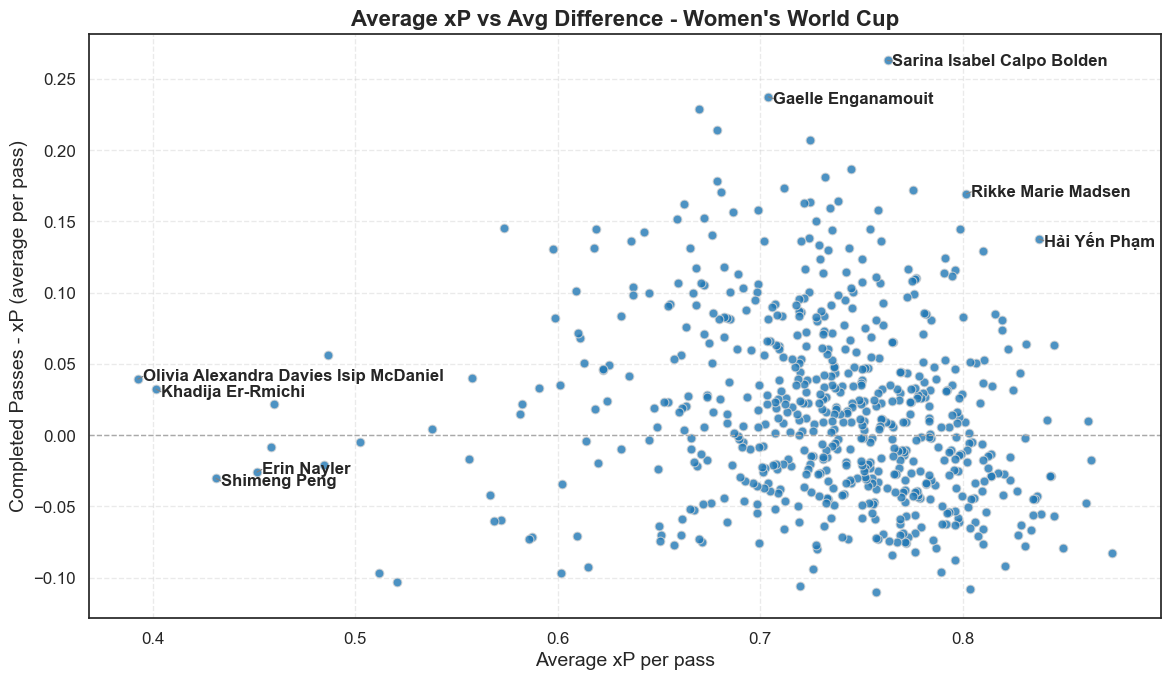

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="white", font_scale=1.1)

def plot_xP_vs_diff_labels(df, title, alternate_left=False):
    df_plot = df.reset_index()  

    plt.figure(figsize=(12, 7))

    # Scatter plot: small points with light border
    sns.scatterplot(
        data=df_plot,
        x='avg_xP',
        y='avg_xP_difference',
        color='#1f77b4',
        s=40,
        alpha=0.8,
        edgecolor='lightgray',
        linewidth=0.8
    )

    plt.axhline(0, color='darkgray', linestyle='--', linewidth=1)

    # Top-right: 4 players closest to top-right corner
    x_norm = (df_plot['avg_xP'] - df_plot['avg_xP'].min()) / (df_plot['avg_xP'].max() - df_plot['avg_xP'].min())
    y_norm = (df_plot['avg_xP_difference'] - df_plot['avg_xP_difference'].min()) / (df_plot['avg_xP_difference'].max() - df_plot['avg_xP_difference'].min())
    df_plot['topright_score'] = x_norm + y_norm
    topright_players = df_plot.nlargest(4, 'topright_score')

    for i, (_, row) in enumerate(topright_players.iterrows()):
        x_offset = 0.005 * (df_plot['avg_xP'].max() - df_plot['avg_xP'].min())
        y_offset = np.random.uniform(-0.005, 0.005) * (df_plot['avg_xP_difference'].max() - df_plot['avg_xP_difference'].min())
        x_text = row['avg_xP'] + x_offset
        y_text = row['avg_xP_difference'] + y_offset
        plt.plot([row['avg_xP'], x_text], [row['avg_xP_difference'], y_text], color='gray', lw=0.8)
        plt.text(x_text, y_text, row['player'], fontsize=12, weight='bold', va='center', ha='left')

    # Left: 4 players with lowest avg_xP
    left_players = df_plot.nsmallest(4, 'avg_xP')
    offsets_vertical = [0.005, -0.005, -0.005, 0.005]  # alternate up/down if needed
    for i, (_, row) in enumerate(left_players.iterrows()):
        x_offset = 0.005 * (df_plot['avg_xP'].max() - df_plot['avg_xP'].min())
        if alternate_left:
            y_offset = offsets_vertical[i] * (df_plot['avg_xP_difference'].max() - df_plot['avg_xP_difference'].min())
        else:
            y_offset = 0.002 * (df_plot['avg_xP_difference'].max() - df_plot['avg_xP_difference'].min())
        x_text = row['avg_xP'] + x_offset
        y_text = row['avg_xP_difference'] + y_offset
        plt.plot([row['avg_xP'], x_text], [row['avg_xP_difference'], y_text], color='gray', lw=0.8)
        plt.text(x_text, y_text, row['player'], fontsize=12, weight='bold', va='center', ha='left')

    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Average xP per pass', fontsize=14)
    plt.ylabel('Completed Passes - xP (average per pass)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


# UEFA Women's Euro (no alternate offsets on left)
euros_df = player_profile_filtered[
    player_profile_filtered['competitions'].apply(lambda x: "Europe - UEFA Women's Euro" in x)
]
plot_xP_vs_diff_labels(euros_df, "Average xP vs Avg Difference - UEFA Women's Euro", alternate_left=False)

# Women's World Cup (alternate offsets on left)
wc_df = player_profile_filtered[
    player_profile_filtered['competitions'].apply(lambda x: "International - Women's World Cup" in x)
]
plot_xP_vs_diff_labels(wc_df, "Average xP vs Avg Difference - Women's World Cup", alternate_left=True)